/Users/benx/anaconda3/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.3844551146030426
Epoch 10, Loss: 0.2617753744125366
Epoch 20, Loss: 0.19048571586608887
Epoch 30, Loss: 0.18328383564949036
Epoch 40, Loss: 0.17427407205104828
Epoch 50, Loss: 0.1701936274766922
Epoch 60, Loss: 0.16753770411014557
Epoch 70, Loss: 0.16415110230445862
Epoch 80, Loss: 0.16026200354099274
Epoch 90, Loss: 0.15521524846553802
Epoch 100, Loss: 0.14801155030727386
Epoch 110, Loss: 0.13689975440502167
Epoch 120, Loss: 0.11900985240936279
Epoch 130, Loss: 0.09067860245704651
Epoch 140, Loss: 0.051716625690460205
Epoch 150, Loss: 0.01861717365682125
Epoch 160, Loss: 0.01372112613171339
Epoch 170, Loss: 0.009657032787799835
Epoch 180, Loss: 0.007047521416097879
Epoch 190, Loss: 0.005267429631203413
Epoch 200, Loss: 0.0035547344014048576
Epoch 210, Loss: 0.0026138818357139826
Epoch 220, Loss: 0.0016888928366824985
Epoch 230, Loss: 0.001639450085349381
Epoch 240, Loss: 0.0010088352719321847
Epoch 250, Loss: 0.0007783889886923134
Epoch 260, Loss: 0.000668392283841967

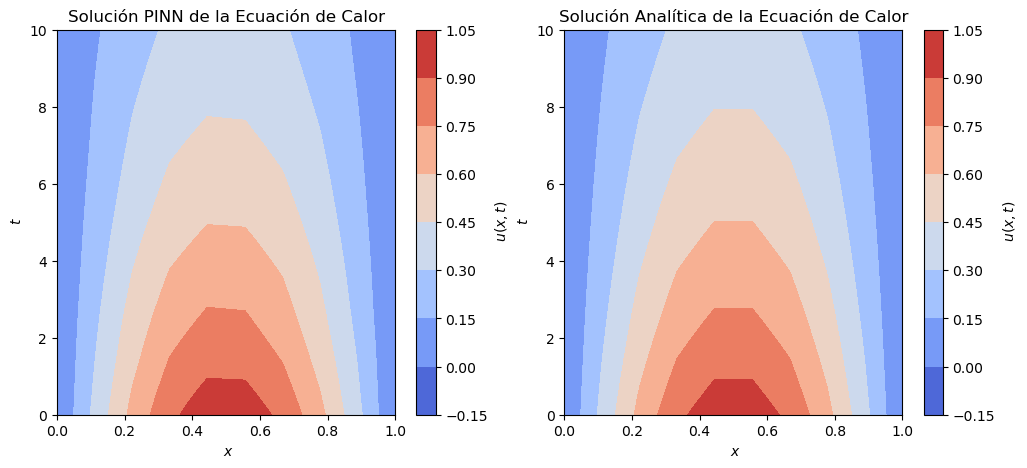

ValueError: operands could not be broadcast together with shapes (10,100) (1000,1) 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Definir la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        x = torch.nn.functional.gelu(self.fc1(inputs))
        x = torch.nn.functional.gelu(self.fc2(x))
        x = torch.nn.functional.gelu(self.fc3(x))
        u_hat = self.fc4(x)
        return u_hat

net = Net()

# Parámetros de la simulación
L = 1.0  # Longitud de la barra
T_max = 10.0  # Tiempo máximo
alpha = 0.01  # Difusividad térmica

# Generar datos sintéticos
x = torch.linspace(0, L, 10).reshape(-1, 1)
t = torch.linspace(0, T_max, 100).reshape(-1, 1)
X, T = torch.meshgrid(x[:, 0], t[:, 0])

# Habilitar gradientes en X y T
X = X.reshape(-1, 1).float().requires_grad_(True)
T = T.reshape(-1, 1).float().requires_grad_(True)

# Condición inicial: u(x, 0) = sin(pi * x)
u_0 = torch.sin(np.pi * x).reshape(-1, 1)

# Condiciones de contorno: u(0, t) = 0, u(L, t) = 0
u_b0 = torch.zeros_like(t)
u_bL = torch.zeros_like(t)

# Definir el optimizador
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Función de pérdida
def loss_fn(x, t, u_hat, alpha):
    # Physics loss
    u_hat_x = torch.autograd.grad(u_hat, x, torch.ones_like(u_hat), create_graph=True)[0]
    u_hat_xx = torch.autograd.grad(u_hat_x, x, torch.ones_like(u_hat_x), create_graph=True)[0]
    u_hat_t = torch.autograd.grad(u_hat, t, torch.ones_like(u_hat), create_graph=True)[0]
    
    phys_residual = u_hat_t - alpha * u_hat_xx
    phys_loss = nn.MSELoss()(phys_residual, torch.zeros_like(phys_residual))
    
    return phys_loss

# Entrenamiento
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Condiciones iniciales y de contorno
    u_hat_0 = net(x, torch.zeros_like(x))
    u_hat_b0 = net(torch.zeros_like(t), t)
    u_hat_bL = net(L * torch.ones_like(t), t)
    
    # Pérdida de las condiciones iniciales y de contorno
    ic_loss = nn.MSELoss()(u_hat_0, u_0)
    bc_loss = nn.MSELoss()(u_hat_b0, u_b0) + nn.MSELoss()(u_hat_bL, u_bL)
    
    # Calcular la predicción de la PINN en el dominio
    u_hat = net(X, T)
    
    # Pérdida total
    loss = loss_fn(X, T, u_hat, alpha) + ic_loss + bc_loss
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Entrenamiento completo")

# Predicciones después del entrenamiento
net.eval()
with torch.no_grad():
    u_pred = net(X, T).numpy().reshape(10, 100)

# Solución analítica
u_analytical = np.exp(-np.pi**2 * alpha * T.detach().numpy()) * np.sin(np.pi * X.detach().numpy())

# Graficar los resultados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X.detach().numpy().reshape(10, 100), T.detach().numpy().reshape(10, 100), u_pred, cmap='coolwarm')
plt.colorbar(label=' $u(x,t)$')
plt.xlabel(' $x$')
plt.ylabel(' $t$')
plt.title('Solución PINN de la Ecuación de Calor')

plt.subplot(1, 2, 2)
plt.contourf(X.detach().numpy().reshape(10, 100), T.detach().numpy().reshape(10, 100), u_analytical.reshape(10, 100), cmap='coolwarm')
plt.colorbar(label=' $u(x,t)$')
plt.xlabel(' $x$')
plt.ylabel(' $t$')
plt.title('Solución Analítica de la Ecuación de Calor')

plt.show()

# Error absoluto medio
error = np.mean(np.abs(u_pred - u_analytical))
print(f"Error absoluto medio entre la solución PINN y la solución analítica: {error}")


Epoch 0, Loss: 0.5979480743408203
Epoch 10, Loss: 0.3230755925178528
Epoch 20, Loss: 0.20587342977523804
Epoch 30, Loss: 0.19400621950626373
Epoch 40, Loss: 0.17780500650405884
Epoch 50, Loss: 0.17375613749027252
Epoch 60, Loss: 0.17051446437835693
Epoch 70, Loss: 0.16788482666015625
Epoch 80, Loss: 0.1654641479253769
Epoch 90, Loss: 0.1626257747411728
Epoch 100, Loss: 0.15906473994255066
Epoch 110, Loss: 0.154290109872818
Epoch 120, Loss: 0.1474406123161316
Epoch 130, Loss: 0.13715523481369019
Epoch 140, Loss: 0.12132036685943604
Epoch 150, Loss: 0.09693173319101334
Epoch 160, Loss: 0.06162632256746292
Epoch 170, Loss: 0.02234376221895218
Epoch 180, Loss: 0.005413969978690147
Epoch 190, Loss: 0.0054377606138587
Epoch 200, Loss: 0.0023112036287784576
Epoch 210, Loss: 0.0019529578275978565
Epoch 220, Loss: 0.0013008968671783805
Epoch 230, Loss: 0.0011356598697602749
Epoch 240, Loss: 0.00080073531717062
Epoch 250, Loss: 0.0007122717215679586
Epoch 260, Loss: 0.0005902163684368134
Epoch 2

Epoch 2070, Loss: 1.5048588466015644e-05
Epoch 2080, Loss: 1.4980582818679977e-05
Epoch 2090, Loss: 1.4915604879206512e-05
Epoch 2100, Loss: 1.4853498214506544e-05
Epoch 2110, Loss: 1.4793454283790197e-05
Epoch 2120, Loss: 1.4735282093170099e-05
Epoch 2130, Loss: 1.4678651496069506e-05
Epoch 2140, Loss: 1.4623274182667956e-05
Epoch 2150, Loss: 1.4569116501661483e-05
Epoch 2160, Loss: 1.451595380785875e-05
Epoch 2170, Loss: 1.4463617844739929e-05
Epoch 2180, Loss: 1.4412066775548737e-05
Epoch 2190, Loss: 1.436137426935602e-05
Epoch 2200, Loss: 1.4316725355456583e-05
Epoch 2210, Loss: 1.5361398254754022e-05
Epoch 2220, Loss: 0.00040329882176592946
Epoch 2230, Loss: 0.00046008697245270014
Epoch 2240, Loss: 8.582635200582445e-05
Epoch 2250, Loss: 2.605697955004871e-05
Epoch 2260, Loss: 3.612826549215242e-05
Epoch 2270, Loss: 1.5632667782483622e-05
Epoch 2280, Loss: 1.6069161574705504e-05
Epoch 2290, Loss: 1.54387453221716e-05
Epoch 2300, Loss: 1.4947712770663202e-05
Epoch 2310, Loss: 1.456

Epoch 4090, Loss: 0.00015387055464088917
Epoch 4100, Loss: 4.798906229552813e-05
Epoch 4110, Loss: 1.886726931843441e-05
Epoch 4120, Loss: 1.5188295037660282e-05
Epoch 4130, Loss: 1.115986924560275e-05
Epoch 4140, Loss: 1.1965043086092919e-05
Epoch 4150, Loss: 6.325926369754598e-05
Epoch 4160, Loss: 0.0001609547616681084
Epoch 4170, Loss: 1.2598075954883825e-05
Epoch 4180, Loss: 3.294577618362382e-05
Epoch 4190, Loss: 1.3550602488976438e-05
Epoch 4200, Loss: 1.069868085323833e-05
Epoch 4210, Loss: 1.0215879228780977e-05
Epoch 4220, Loss: 9.861903890850954e-06
Epoch 4230, Loss: 9.46703312365571e-06
Epoch 4240, Loss: 9.30978058022447e-06
Epoch 4250, Loss: 9.239525752491318e-06
Epoch 4260, Loss: 9.29105135583086e-06
Epoch 4270, Loss: 1.1649234693322796e-05
Epoch 4280, Loss: 0.00016306336328852922
Epoch 4290, Loss: 7.019417535047978e-05
Epoch 4300, Loss: 1.6644084098516032e-05
Epoch 4310, Loss: 1.5307054127333686e-05
Epoch 4320, Loss: 2.1259456843836233e-05
Epoch 4330, Loss: 1.024666016746

Epoch 6130, Loss: 1.831270128604956e-05
Epoch 6140, Loss: 6.912359367561294e-06
Epoch 6150, Loss: 1.0319516150048003e-05
Epoch 6160, Loss: 7.638196620973758e-06
Epoch 6170, Loss: 7.0096857598400675e-06
Epoch 6180, Loss: 8.495544534525834e-06
Epoch 6190, Loss: 7.755120168440044e-05
Epoch 6200, Loss: 2.172400854760781e-05
Epoch 6210, Loss: 6.917207792866975e-05
Epoch 6220, Loss: 1.0498834853933658e-05
Epoch 6230, Loss: 1.699522545095533e-05
Epoch 6240, Loss: 9.786033842829056e-06
Epoch 6250, Loss: 7.114838354027597e-06
Epoch 6260, Loss: 7.405946689686971e-06
Epoch 6270, Loss: 9.842376130109187e-06
Epoch 6280, Loss: 6.329111783998087e-05
Epoch 6290, Loss: 2.039354876615107e-05
Epoch 6300, Loss: 1.6821708413772285e-05
Epoch 6310, Loss: 1.2170339687145315e-05
Epoch 6320, Loss: 7.129616278689355e-06
Epoch 6330, Loss: 7.569787612737855e-06
Epoch 6340, Loss: 9.97082497633528e-06
Epoch 6350, Loss: 5.288576357997954e-05
Epoch 6360, Loss: 6.723641126882285e-05
Epoch 6370, Loss: 2.0246185158612207

Epoch 8180, Loss: 0.00014133033982943743
Epoch 8190, Loss: 6.95422277203761e-05
Epoch 8200, Loss: 2.577781015133951e-05
Epoch 8210, Loss: 1.2546657671919093e-05
Epoch 8220, Loss: 6.406298780348152e-06
Epoch 8230, Loss: 6.441649475164013e-06
Epoch 8240, Loss: 5.490409876074409e-06
Epoch 8250, Loss: 6.163410489534726e-06
Epoch 8260, Loss: 2.3726679501123726e-05
Epoch 8270, Loss: 5.640602466883138e-05
Epoch 8280, Loss: 1.430753582098987e-05
Epoch 8290, Loss: 9.882158337859437e-06
Epoch 8300, Loss: 6.5877334236574825e-06
Epoch 8310, Loss: 6.753014531568624e-06
Epoch 8320, Loss: 6.8211952566343825e-06
Epoch 8330, Loss: 1.678157423157245e-05
Epoch 8340, Loss: 9.649835556047037e-05
Epoch 8350, Loss: 2.0283780031604692e-05
Epoch 8360, Loss: 1.2532664186437614e-05
Epoch 8370, Loss: 2.5492015993222594e-05
Epoch 8380, Loss: 8.916380465961993e-06
Epoch 8390, Loss: 1.5283560060197487e-05
Epoch 8400, Loss: 1.7419242794858292e-05
Epoch 8410, Loss: 6.5772273956099525e-06
Epoch 8420, Loss: 2.1671592548

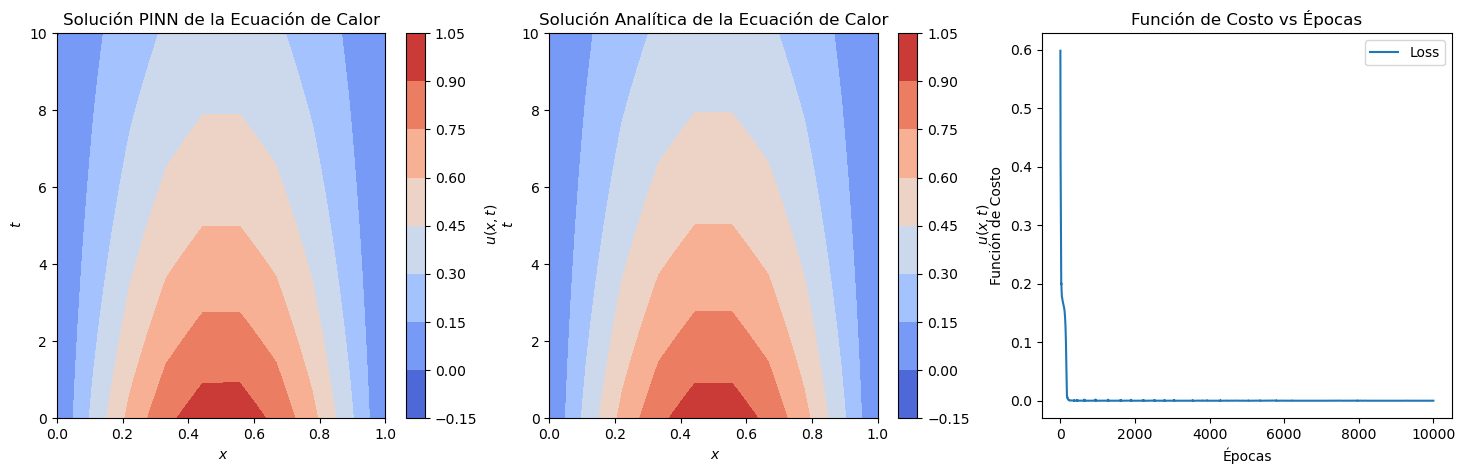

ValueError: operands could not be broadcast together with shapes (10,100) (1000,1) 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Definir la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        x = torch.nn.functional.gelu(self.fc1(inputs))
        x = torch.nn.functional.gelu(self.fc2(x))
        x = torch.nn.functional.gelu(self.fc3(x))
        u_hat = self.fc4(x)
        return u_hat

net = Net()

# Parámetros de la simulación
L = 1.0  # Longitud de la barra
T_max = 10.0  # Tiempo máximo
alpha = 0.01  # Difusividad térmica

# Generar datos sintéticos
x = torch.linspace(0, L, 10).reshape(-1, 1)
t = torch.linspace(0, T_max, 100).reshape(-1, 1)
X, T = torch.meshgrid(x[:, 0], t[:, 0])

# Habilitar gradientes en X y T
X = X.reshape(-1, 1).float().requires_grad_(True)
T = T.reshape(-1, 1).float().requires_grad_(True)

# Condición inicial: u(x, 0) = sin(pi * x)
u_0 = torch.sin(np.pi * x).reshape(-1, 1)

# Condiciones de contorno: u(0, t) = 0, u(L, t) = 0
u_b0 = torch.zeros_like(t)
u_bL = torch.zeros_like(t)

# Definir el optimizador
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Función de pérdida
def loss_fn(x, t, u_hat, alpha):
    # Physics loss
    u_hat_x = torch.autograd.grad(u_hat, x, torch.ones_like(u_hat), create_graph=True)[0]
    u_hat_xx = torch.autograd.grad(u_hat_x, x, torch.ones_like(u_hat_x), create_graph=True)[0]
    u_hat_t = torch.autograd.grad(u_hat, t, torch.ones_like(u_hat), create_graph=True)[0]
    
    phys_residual = u_hat_t - alpha * u_hat_xx
    phys_loss = nn.MSELoss()(phys_residual, torch.zeros_like(phys_residual))
    
    return phys_loss

# Lista para almacenar la pérdida en cada época
loss_history = []

# Entrenamiento
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Condiciones iniciales y de contorno
    u_hat_0 = net(x, torch.zeros_like(x))
    u_hat_b0 = net(torch.zeros_like(t), t)
    u_hat_bL = net(L * torch.ones_like(t), t)
    
    # Pérdida de las condiciones iniciales y de contorno
    ic_loss = nn.MSELoss()(u_hat_0, u_0)
    bc_loss = nn.MSELoss()(u_hat_b0, u_b0) + nn.MSELoss()(u_hat_bL, u_bL)
    
    # Calcular la predicción de la PINN en el dominio
    u_hat = net(X, T)
    
    # Pérdida total
    loss = loss_fn(X, T, u_hat, alpha) + ic_loss + bc_loss
    loss.backward()
    optimizer.step()
    
    # Guardar la pérdida en la lista
    loss_history.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Entrenamiento completo")

# Predicciones después del entrenamiento
net.eval()
with torch.no_grad():
    u_pred = net(X, T).numpy().reshape(10, 100)

# Solución analítica
u_analytical = np.exp(-np.pi**2 * alpha * T.detach().numpy()) * np.sin(np.pi * X.detach().numpy())

# Graficar los resultados
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.contourf(X.detach().numpy().reshape(10, 100), T.detach().numpy().reshape(10, 100), u_pred, cmap='coolwarm')
plt.colorbar(label=' $u(x,t)$')
plt.xlabel(' $x$')
plt.ylabel(' $t$')
plt.title('Solución PINN de la Ecuación de Calor')

plt.subplot(1, 3, 2)
plt.contourf(X.detach().numpy().reshape(10, 100), T.detach().numpy().reshape(10, 100), u_analytical.reshape(10, 100), cmap='coolwarm')
plt.colorbar(label=' $u(x,t)$')
plt.xlabel(' $x$')
plt.ylabel(' $t$')
plt.title('Solución Analítica de la Ecuación de Calor')

# Graficar la función de costo contra las épocas
plt.subplot(1, 3, 3)
plt.plot(loss_history, label='Loss')
plt.xlabel('Épocas')
plt.ylabel('Función de Costo')
plt.title('Función de Costo vs Épocas')
plt.legend()

plt.show()

# Error absoluto medio
error = np.mean(np.abs(u_pred - u_analytical))
print(f"Error absoluto medio entre la solución PINN y la solución analítica: {error}")


Epoch 0, Loss: 0.32161152362823486
Epoch 10, Loss: 0.20430497825145721
Epoch 20, Loss: 0.18424668908119202
Epoch 30, Loss: 0.17612333595752716
Epoch 40, Loss: 0.17035837471485138
Epoch 50, Loss: 0.16602769494056702
Epoch 60, Loss: 0.1607634723186493
Epoch 70, Loss: 0.1526324450969696
Epoch 80, Loss: 0.13878120481967926
Epoch 90, Loss: 0.11407440900802612
Epoch 100, Loss: 0.0723017230629921
Epoch 110, Loss: 0.02080230973660946
Epoch 120, Loss: 0.005371561273932457
Epoch 130, Loss: 0.004206015728414059
Epoch 140, Loss: 0.0019452504348009825
Epoch 150, Loss: 0.0017052025068551302
Epoch 160, Loss: 0.001159343752078712
Epoch 170, Loss: 0.0009500934975221753
Epoch 180, Loss: 0.0007732674130238593
Epoch 190, Loss: 0.0006605893140658736
Epoch 200, Loss: 0.0013658595271408558
Epoch 210, Loss: 0.0006947637302801013
Epoch 220, Loss: 0.0008135006064549088
Epoch 230, Loss: 0.0006003198213875294
Epoch 240, Loss: 0.0005082151619717479
Epoch 250, Loss: 0.00043542825733311474
Epoch 260, Loss: 0.0003961

Epoch 2040, Loss: 3.605403617257252e-05
Epoch 2050, Loss: 3.600082709454e-05
Epoch 2060, Loss: 3.594782901927829e-05
Epoch 2070, Loss: 3.589450352592394e-05
Epoch 2080, Loss: 3.584129080991261e-05
Epoch 2090, Loss: 3.5788281820714474e-05
Epoch 2100, Loss: 3.573492722352967e-05
Epoch 2110, Loss: 3.568176180124283e-05
Epoch 2120, Loss: 3.5628527257358655e-05
Epoch 2130, Loss: 3.557500895112753e-05
Epoch 2140, Loss: 3.5521752579370514e-05
Epoch 2150, Loss: 3.546836887835525e-05
Epoch 2160, Loss: 3.541503247106448e-05
Epoch 2170, Loss: 3.5361736081540585e-05
Epoch 2180, Loss: 3.5308461519889534e-05
Epoch 2190, Loss: 3.5255208786111325e-05
Epoch 2200, Loss: 3.5201945138396695e-05
Epoch 2210, Loss: 3.514868512866087e-05
Epoch 2220, Loss: 3.5095181374344975e-05
Epoch 2230, Loss: 3.5041855880990624e-05
Epoch 2240, Loss: 3.498842124827206e-05
Epoch 2250, Loss: 3.493516851449385e-05
Epoch 2260, Loss: 3.488165748422034e-05
Epoch 2270, Loss: 3.4828488423954695e-05
Epoch 2280, Loss: 3.4775177482515

Epoch 4050, Loss: 3.087103686993942e-05
Epoch 4060, Loss: 3.086544165853411e-05
Epoch 4070, Loss: 3.08602539007552e-05
Epoch 4080, Loss: 3.0854502256261185e-05
Epoch 4090, Loss: 3.084916897932999e-05
Epoch 4100, Loss: 3.084348645643331e-05
Epoch 4110, Loss: 3.083760748268105e-05
Epoch 4120, Loss: 3.083211777266115e-05
Epoch 4130, Loss: 3.082654075114988e-05
Epoch 4140, Loss: 3.082078183069825e-05
Epoch 4150, Loss: 3.081501927226782e-05
Epoch 4160, Loss: 3.0809118470642716e-05
Epoch 4170, Loss: 3.080345777561888e-05
Epoch 4180, Loss: 3.0797709769103676e-05
Epoch 4190, Loss: 3.0791768949711695e-05
Epoch 4200, Loss: 3.078606823692098e-05
Epoch 4210, Loss: 3.078000736422837e-05
Epoch 4220, Loss: 3.077391374972649e-05
Epoch 4230, Loss: 3.076830034842715e-05
Epoch 4240, Loss: 3.076215216424316e-05
Epoch 4250, Loss: 3.0756316846236587e-05
Epoch 4260, Loss: 3.0750128644285724e-05
Epoch 4270, Loss: 3.074406777159311e-05
Epoch 4280, Loss: 3.073804691666737e-05
Epoch 4290, Loss: 3.07318550767377e

Epoch 6030, Loss: 3.0214181606424972e-05
Epoch 6040, Loss: 3.0213248464860953e-05
Epoch 6050, Loss: 3.0212349884095602e-05
Epoch 6060, Loss: 3.021150769200176e-05
Epoch 6070, Loss: 3.0210730983526446e-05
Epoch 6080, Loss: 3.0209874239517376e-05
Epoch 6090, Loss: 3.020913754880894e-05
Epoch 6100, Loss: 3.020830627065152e-05
Epoch 6110, Loss: 3.020730582647957e-05
Epoch 6120, Loss: 3.0206401788746007e-05
Epoch 6130, Loss: 3.0205615985323675e-05
Epoch 6140, Loss: 3.0204708309611306e-05
Epoch 6150, Loss: 3.020379153895192e-05
Epoch 6160, Loss: 3.0202985726646148e-05
Epoch 6170, Loss: 3.0201947083696723e-05
Epoch 6180, Loss: 3.0201390472939238e-05
Epoch 6190, Loss: 3.0200420951587148e-05
Epoch 6200, Loss: 3.0199502361938357e-05
Epoch 6210, Loss: 3.019871837750543e-05
Epoch 6220, Loss: 3.0197674277587794e-05
Epoch 6230, Loss: 3.019677023985423e-05
Epoch 6240, Loss: 3.0195909857866354e-05
Epoch 6250, Loss: 3.0195094950613566e-05
Epoch 6260, Loss: 3.019407631654758e-05
Epoch 6270, Loss: 3.0192

Epoch 8010, Loss: 3.011724584212061e-05
Epoch 8020, Loss: 3.0117236747173592e-05
Epoch 8030, Loss: 3.011732769664377e-05
Epoch 8040, Loss: 3.01171385217458e-05
Epoch 8050, Loss: 3.0117098503978923e-05
Epoch 8060, Loss: 3.0117120331851766e-05
Epoch 8070, Loss: 3.0117007554508746e-05
Epoch 8080, Loss: 3.011699482158292e-05
Epoch 8090, Loss: 3.0116889320197515e-05
Epoch 8100, Loss: 3.011676380992867e-05
Epoch 8110, Loss: 3.0116618290776387e-05
Epoch 8120, Loss: 3.0116483685560524e-05
Epoch 8130, Loss: 3.011648186657112e-05
Epoch 8140, Loss: 3.0116418201941997e-05
Epoch 8150, Loss: 3.0116283596726134e-05
Epoch 8160, Loss: 3.0116221751086414e-05
Epoch 8170, Loss: 3.011616900039371e-05
Epoch 8180, Loss: 3.011621993209701e-05
Epoch 8190, Loss: 3.0116116249701008e-05
Epoch 8200, Loss: 3.0116088964859955e-05
Epoch 8210, Loss: 3.0115970730548725e-05
Epoch 8220, Loss: 3.011600347235799e-05
Epoch 8230, Loss: 3.01159070659196e-05
Epoch 8240, Loss: 3.011583430634346e-05
Epoch 8250, Loss: 3.011562876

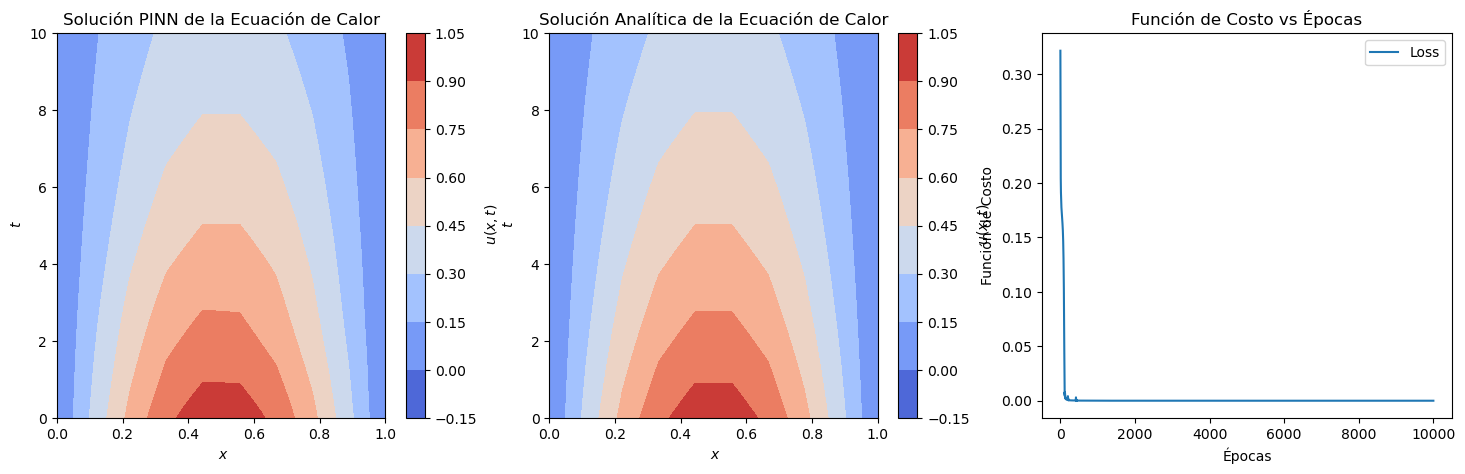

Error absoluto medio entre la solución PINN y la solución analítica: 0.0019771051593124866


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Definir la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        x = torch.nn.functional.gelu(self.fc1(inputs))
        x = torch.nn.functional.gelu(self.fc2(x))
        x = torch.nn.functional.gelu(self.fc3(x))
        u_hat = self.fc4(x)
        return u_hat

net = Net()

# Parámetros de la simulación
L = 1.0  # Longitud de la barra
T_max = 10.0  # Tiempo máximo
alpha = 0.01  # Difusividad térmica

# Generar datos sintéticos
x = torch.linspace(0, L, 10).reshape(-1, 1)
t = torch.linspace(0, T_max, 100).reshape(-1, 1)
X, T = torch.meshgrid(x[:, 0], t[:, 0])

# Habilitar gradientes en X y T
X = X.reshape(-1, 1).float().requires_grad_(True)
T = T.reshape(-1, 1).float().requires_grad_(True)

# Condición inicial: u(x, 0) = sin(pi * x)
u_0 = torch.sin(np.pi * x).reshape(-1, 1)

# Condiciones de contorno: u(0, t) = 0, u(L, t) = 0
u_b0 = torch.zeros_like(t)
u_bL = torch.zeros_like(t)

# Definir el optimizador
initial_lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=initial_lr)

# Función de pérdida
def loss_fn(x, t, u_hat, alpha):
    # Physics loss
    u_hat_x = torch.autograd.grad(u_hat, x, torch.ones_like(u_hat), create_graph=True)[0]
    u_hat_xx = torch.autograd.grad(u_hat_x, x, torch.ones_like(u_hat_x), create_graph=True)[0]
    u_hat_t = torch.autograd.grad(u_hat, t, torch.ones_like(u_hat), create_graph=True)[0]
    
    phys_residual = u_hat_t - alpha * u_hat_xx
    phys_loss = nn.MSELoss()(phys_residual, torch.zeros_like(phys_residual))
    
    return phys_loss

# Lista para almacenar la pérdida en cada época
loss_history = []

# Entrenamiento
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Reducir el learning rate cada 500 épocas
    if epoch > 0 and epoch % 500 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 2
        print(f"Epoch {epoch}: Learning rate reducido a la mitad")

    # Condiciones iniciales y de contorno
    u_hat_0 = net(x, torch.zeros_like(x))
    u_hat_b0 = net(torch.zeros_like(t), t)
    u_hat_bL = net(L * torch.ones_like(t), t)
    
    # Pérdida de las condiciones iniciales y de contorno
    ic_loss = nn.MSELoss()(u_hat_0, u_0)
    bc_loss = nn.MSELoss()(u_hat_b0, u_b0) + nn.MSELoss()(u_hat_bL, u_bL)
    
    # Calcular la predicción de la PINN en el dominio
    u_hat = net(X, T)
    
    # Pérdida total
    loss = loss_fn(X, T, u_hat, alpha) + ic_loss + bc_loss
    loss.backward()
    optimizer.step()
    
    # Guardar la pérdida en la lista
    loss_history.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Entrenamiento completo")

# Predicciones después del entrenamiento
net.eval()
with torch.no_grad():
    u_pred = net(X, T).numpy().reshape(10, 100)

# Solución analítica
u_analytical = np.exp(-np.pi**2 * alpha * T.detach().numpy()) * np.sin(np.pi * X.detach().numpy())
u_analytical = u_analytical.reshape(10, 100)

# Graficar los resultados
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.contourf(X.detach().numpy().reshape(10, 100), T.detach().numpy().reshape(10, 100), u_pred, cmap='coolwarm')
plt.colorbar(label=' $u(x,t)$')
plt.xlabel(' $x$')
plt.ylabel(' $t$')
plt.title('Solución PINN de la Ecuación de Calor')

plt.subplot(1, 3, 2)
plt.contourf(X.detach().numpy().reshape(10, 100), T.detach().numpy().reshape(10, 100), u_analytical, cmap='coolwarm')
plt.colorbar(label=' $u(x,t)$')
plt.xlabel(' $x$')
plt.ylabel(' $t$')
plt.title('Solución Analítica de la Ecuación de Calor')

# Graficar la función de costo contra las épocas
plt.subplot(1, 3, 3)
plt.plot(loss_history, label='Loss')
plt.xlabel('Épocas')
plt.ylabel('Función de Costo')
plt.title('Función de Costo vs Épocas')
plt.legend()

plt.show()

# Error absoluto medio
error = np.mean(np.abs(u_pred - u_analytical))
print(f"Error absoluto medio entre la solución PINN y la solución analítica: {error}")
